In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mljar-supervised
!pip install joblib==1.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 KB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 KB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 10.3 MB/s eta 0:00:00
  Created wheel for mljar-supervised: filename=mljar_supervised-0.11.5-py3-none-any.whl size=147060 sha256=01461394f35a5918c2cada49b3701ebfdf416b1e98ba4db0fcdb7f26946849a9
  Stored in directory: /root/.cache/pip/whe

In [3]:
# set project folder directory
DATA_DIR = '/content/drive/MyDrive/W281 Project/data'

In [4]:
# load some lib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import joblib

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA

# performing AUTOML
# Trying AutoML to determine golden features
# also because I am lazy to try all modeling techniques...
from supervised.automl import AutoML
import gzip

# read in metadata
df_meta = pd.read_csv(f"{DATA_DIR}/raw/Chest_xray_Corona_Metadata.csv", index_col = 0)
df_meta

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


# Loading Data
Begining Modeling

In [5]:
# import data - This should be feature sepecfific
# NOTE: this step is feature specific
# train_image_data =  pickle.load(open(f"{DATA_DIR}/processed/lbp_image_data.pkl", "rb"))
# train_label =  pickle.load(open(f"{DATA_DIR}/processed/lbp_caption_data.pkl", "rb"))

# joblib load
train_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_features_image_data.gz", 'rb') )
train_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_caption_data.gz", 'rb') )


# loading test set
test_image_data = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_features_test_image_data.gz", 'rb') )
test_label = joblib.load( gzip.GzipFile(f"{DATA_DIR}/processed/combined_test_caption_data.gz", 'rb') )

# load using joblib
# test_image_data = joblib.load(f"{DATA_DIR}/processed/clrs_hist_image_data.pkl")
# test_label = joblib.load(f"{DATA_DIR}/processed/clrs_hist_test_caption_data.pkl")


In [6]:
# compute PCA on the SIFT features
# applying PCA components = 10 or 20 from earlier analysis
# let's do 10 to reduce the training time a little bit
pca=PCA(n_components=20) 
train_image_data_pca=pca.fit_transform(train_image_data['sift'])

# applying the same transformation on the test image data
test_image_data_pca=pca.transform(test_image_data['sift'])

# Training Simple Multiclass Logistic Regression
Utilizing SIFT features only, train a simple logistic regression

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # 1. declare a keras sequential model that's 
  # 2. add first layer for a flatten input layer
  # 3. add dense hidden layer size based on the input list 
  # 4. add a final output layer with softmax activation for multi-class classification purposes
  model = keras.Sequential()
  model.add(keras.layers.Flatten())

  for layer_size in hidden_layer_sizes:
    model.add(keras.layers.Dense(
      units=layer_size,
      activation=activation
    ))

  model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
  ))


  # 5. instantiate an optimization based on input
  if optimizer == 'SGD':
    op = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  elif optimizer == 'Adam':
    op = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  # compile the model with an opimizer
  model.compile(loss="sparse_categorical_crossentropy", 
                optimizer=op, 
                metrics=['accuracy'])


  return model

In [ ]:
# Build the model.
log_reg_model = build_model(n_classes=3, 
                    hidden_layer_sizes=[512, 256],
                    activation='relu',
                    optimizer='Adam',
                    learning_rate=0.01)


# keras.utils.plot_model(log_reg_model, show_shapes=True, dpi=90)               

In [ ]:
history = log_reg_model.fit(
  x=train_image_data_pca,
  y=train_label,
  epochs=10,
  batch_size=64,
  validation_split=0.1)

Epoch 1/10
279/279 [==============================] - 2s 5ms/step - loss: 4.6081 - accuracy: 0.5750 - val_loss: 1.1168 - val_accuracy: 0.4697
Epoch 2/10
279/279 [==============================] - 1s 4ms/step - loss: 0.8619 - accuracy: 0.6136 - val_loss: 1.1865 - val_accuracy: 0.4495
Epoch 3/10
279/279 [==============================] - 1s 4ms/step - loss: 0.8657 - accuracy: 0.6155 - val_loss: 1.2049 - val_accuracy: 0.4535
Epoch 4/10
279/279 [==============================] - 1s 4ms/step - loss: 0.8600 - accuracy: 0.6145 - val_loss: 1.1940 - val_accuracy: 0.4449
Epoch 5/10
279/279 [==============================] - 1s 5ms/step - loss: 0.8569 - accuracy: 0.6191 - val_loss: 1.1395 - val_accuracy: 0.4682
Epoch 6/10
279/279 [==============================] - 1s 4ms/step - loss: 0.8625 - accuracy: 0.6157 - val_loss: 1.0330 - val_accuracy: 0.4985
Epoch 7/10
279/279 [==============================] - 1s 4ms/step - loss: 0.8677 - accuracy: 0.6164 - val_loss: 1.0319 - val_accuracy: 0.4697
Epoch 

In [ ]:
joblib.dump(log_reg_model, f"{DATA_DIR}/outputs/Logistic-SIFT-PCA-ncomp20.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/Logistic-SIFT-PCA-ncomp20.pkl']

In [7]:
log_reg_model = joblib.load(f"{DATA_DIR}/outputs/Logistic-SIFT-PCA-ncomp20.pkl")

In [8]:
y_pred = np.argmax(log_reg_model.predict(test_image_data_pca), axis=-1)
y_pred

94/94 [==============================] - 1s 2ms/step


array([2, 0, 0, ..., 2, 2, 2])

Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

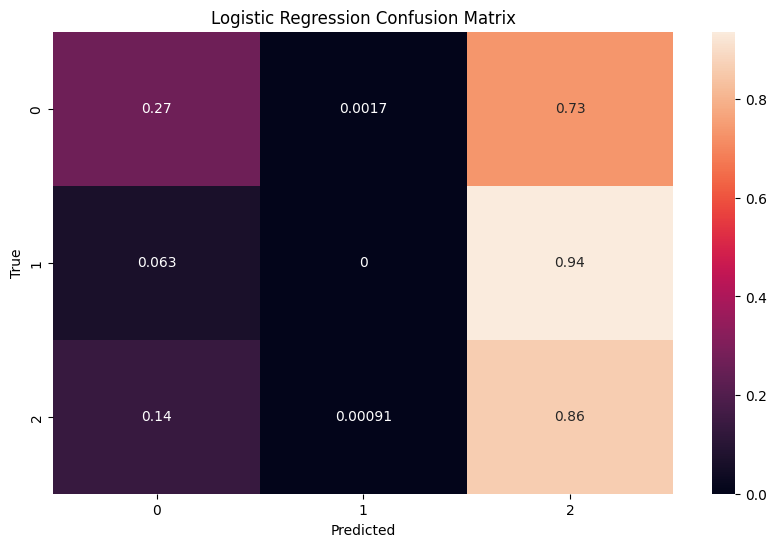

In [11]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Logistic Regression Confusion Matrix")

In [12]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.27      0.37      1168
           1       0.00      0.00      0.00       712
           2       0.38      0.86      0.53      1097

    accuracy                           0.42      2977
   macro avg       0.33      0.38      0.30      2977
weighted avg       0.38      0.42      0.34      2977



# Modeling USING SVM

In [ ]:
# train a quick SVM
from sklearn.svm import SVC

svc_model = SVC(gamma='auto')
svc_model.fit(train_image_data_pca, train_label)

SVC(gamma='auto')

In [ ]:
joblib.dump(svc_model, f"{DATA_DIR}/outputs/SVC-SIFT-PCA-ncomp20.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/SVC-SIFT-PCA-ncomp20.pkl']

In [13]:
svc_model = joblib.load(f"{DATA_DIR}/outputs/SVC-SIFT-PCA-ncomp20.pkl")

In [14]:
y_pred = svc_model.predict(test_image_data_pca)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'SVC Confusion Matrix')

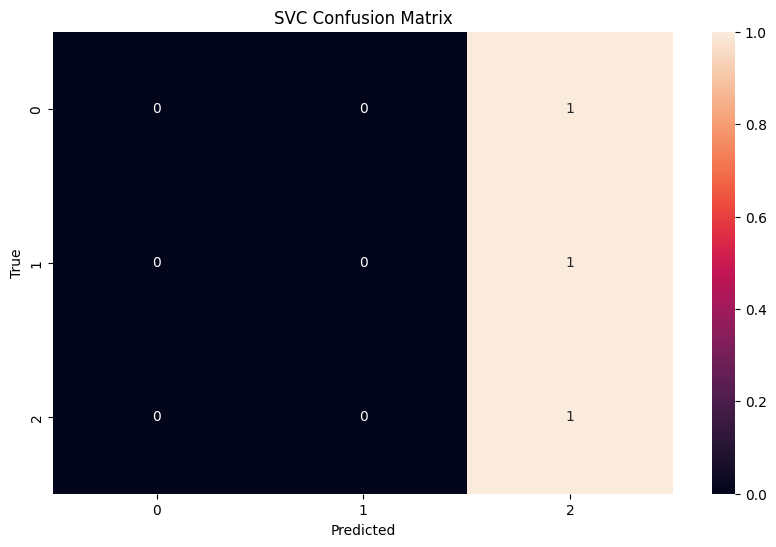

In [16]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVC Confusion Matrix")

In [17]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1168
           1       0.00      0.00      0.00       712
           2       0.37      1.00      0.54      1097

    accuracy                           0.37      2977
   macro avg       0.12      0.33      0.18      2977
weighted avg       0.14      0.37      0.20      2977



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


# Modeling Using Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier


In [ ]:
gbc_model = GradientBoostingClassifier(n_estimators=300, 
                                       learning_rate=0.1,
                                      max_depth=3).fit(train_image_data_pca, train_label)
gbc_model.score(test_image_data_pca, test_label)

0.5361101780315755

In [ ]:
joblib.dump(gbc_model, f"{DATA_DIR}/outputs/GBC-SIFT-PCA-ncomp20.pkl")

['/content/drive/MyDrive/W281 Project/data/outputs/GBC-SIFT-PCA-ncomp20.pkl']

In [18]:
gbc_model = joblib.load(f"{DATA_DIR}/outputs/GBC-SIFT-PCA-ncomp20.pkl")

In [19]:
y_pred = gbc_model.predict(test_image_data_pca)
y_pred

array([2, 2, 2, ..., 2, 2, 2])

Text(0.5, 1.0, 'GBC Confusion Matrix')

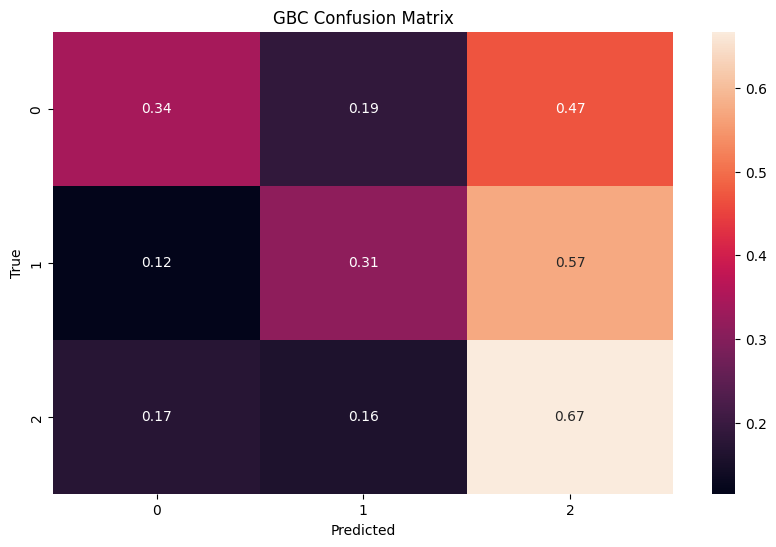

In [20]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("GBC Confusion Matrix")

In [21]:
print(classification_report(test_label, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.34      0.44      1168
           1       0.36      0.31      0.33       712
           2       0.43      0.67      0.53      1097

    accuracy                           0.45      2977
   macro avg       0.46      0.44      0.43      2977
weighted avg       0.48      0.45      0.44      2977



In [ ]:


automl = AutoML(
    mode="Perform", 
    explain_level=1, 
    golden_features=True,
    total_time_limit=30000,
    ml_task="multiclass_classification",
    eval_metric='accuracy',
    validation_strategy={
        "validation_type": "kfold",
        "k_folds": 4,
        "shuffle": False,
        "stratify": True,
})

# upsample training 
automl.fit(train_image_data_pca, train_label)

# save the autoML for future usage
joblib.dump(automl, f"{DATA_DIR}/outputs/SIFT-autMLModel-PCA-ncomp20.pkl")

# print the nice report :)
automl.report()

Output hidden; open in https://colab.research.google.com to view.

In [22]:
automl = joblib.load(f"{DATA_DIR}/outputs/SIFT-autMLModel-PCA-ncomp20.pkl")

[14:36:16] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:36:16] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[14:36:16] WARNING: ../src/learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, pl

In [23]:
# print the report
y_pred = automl.predict(test_image_data_pca)
y_pred

array([0, 2, 2, ..., 2, 2, 2], dtype=int32)

Text(0.5, 1.0, 'AutoML Confusion Matrix')

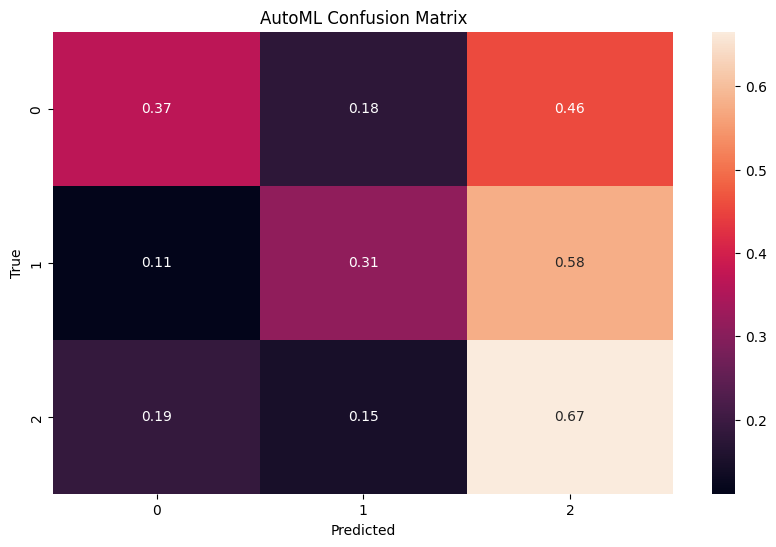

In [24]:
ccm = tf.math.confusion_matrix(test_label, y_pred)
ccm = ccm/ccm.numpy().sum(axis=1)[:, tf.newaxis]

#display that new confusion matrix
plt.figure(figsize=(10,6))
sns.heatmap(
    ccm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("AutoML Confusion Matrix")

In [ ]:
data = {
    "Logistic Regression": 0.39,
    "SVC": 0.37,
    "GBC": 0.54,
    "autoML": 0.62
}

accuracy = pd.DataFrame().from_dict(data, orient='index')
accuracy

,0
Logistic Regression,0.39
SVC,0.37
GBC,0.54
autoML,0.62


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'SVC'),
  Text(2, 0, 'GBC'),
  Text(3, 0, 'autoML')])

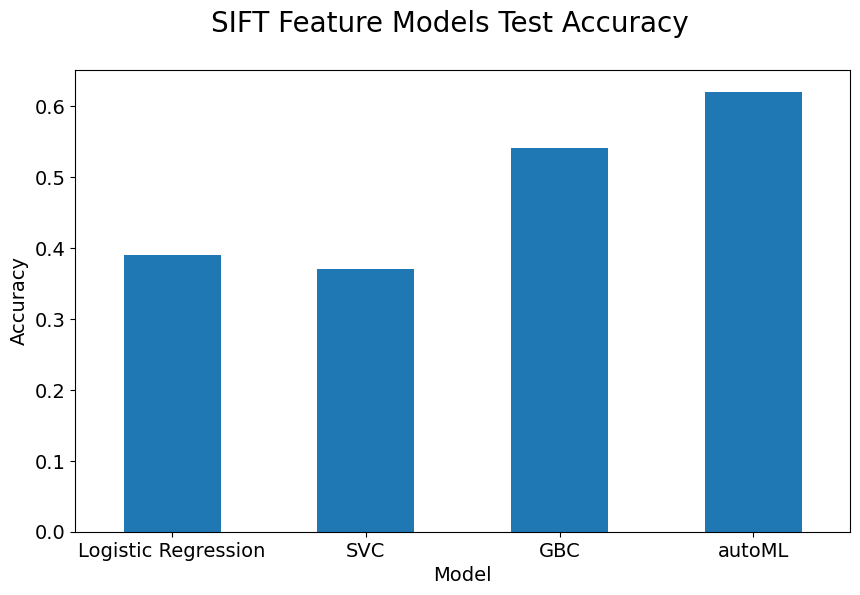

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
accuracy[0].plot(kind='bar')
# set figure title

fig.suptitle('SIFT Feature Models Test Accuracy', fontsize=20)
# set x and y labels
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
